In [2]:
import os, glob, re, random, gzip, json, pysam
from collections import Counter, defaultdict, OrderedDict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Complexity of libraries estimated by Preseq

In [11]:
# Only autosome
genome_size = 0
with open("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.sizes") as f:
    for line in f:
        chrom, length = line.strip("\n").split("\t")
        length = int(length)
        if not re.match("^chr[0-9]+$", chrom):
            continue
        genome_size += length     
print("Genome size of autosomes:", genome_size)

Genome size of autosomes: 2875001522


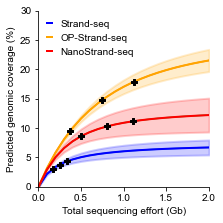

In [6]:
def get_genomic_coverage(name, genome_size):
    df = pd.read_csv("results/%s.qc_pass.tsv" % name, sep="\t")
    array = []
    for run, cell in df[["Run", "Cell"]].values:
        if name == "NanoStrand-seq":
            path = "../../1_NanoStrandSeq/results/stat/preseq/%s/%s/%s.tsv" % (run, cell, cell)
        else:
            path = "../../2_StrandSeq/results/stat/preseq/%s/%s/%s.tsv" % (run, cell, cell)
        if os.path.exists(path):
            d = pd.read_csv(path, sep="\t", index_col=0)
            d = d[d.index <= 2e9]
            s = d["EXPECTED_COVERED_BASES"] * 100 / genome_size
            s.name = cell
            array.append(s)
    m = pd.concat(array, axis=1)
    return m

def get_average_depth(name, genome_size, xs, ys):
    df = pd.read_csv("results/%s.qc_pass.tsv" % name, sep="\t")
    array = []
    for run, cell, depth in df[["Run", "Cell", "GenomicDepth"]].values:
        array.append(depth * genome_size / 1e9)
    mean = np.mean(array)
    std = np.std(array)

    xs1 = [mean - std, mean, mean + std]
    ys1 = []
    for x1 in xs1:
        y1 = 0
        for j in range(len(xs) - 1):
            if xs[j] <= x1 < xs[j + 1]:
                y1 = ys[j] + (ys[j + 1] - ys[j]) * (x1 - xs[j]) / (xs[j + 1] - xs[j])
                break
        ys1.append(y1)
    return xs1, ys1

names = ["Strand-seq", "OP-Strand-seq", "NanoStrand-seq"]
colors = ["blue", "orange", "red"]
alpha = 0.2
plt.figure(figsize=(3.2, 3.2))
for i, name in enumerate(names):
    m = get_genomic_coverage(name, genome_size)    
    means = m.mean(axis=1).values
    stds = m.std(axis=1).values
    xs = m.index / 1e9
    plt.plot(xs, means)
    label = name
    plt.plot(xs, means, lw=2, color=colors[i], label=label)
    plt.fill_between(xs, means - stds, means + stds, lw=2, alpha=alpha, color=colors[i])    
    if True:
        xs1, ys1 = get_average_depth(name, genome_size, xs, means)
        plt.scatter(xs1, ys1, color="black", marker="P", s=30, zorder=10)
ylim = 30
plt.xlim(0, 2)
plt.ylim(0, ylim)
plt.xticks([0, 0.5, 1, 1.5, 2])
plt.yticks(np.arange(0, ylim + 1, 5), np.arange(0, ylim + 1, 5))
plt.xlabel("Total sequencing effort (Gb)")
plt.ylabel("Predicted genomic coverage (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(loc="upper left", handlelength=0.5, frameon=False, ncol=1)
plt.tight_layout()
plt.savefig("figures/genomic_coverage.predicted.pdf", dpi=300)

# Final genomic coverage

Strand-seq 3.4577461931810096 3.5050413096790005
OP-Strand-seq 12.922594433626482 13.046351528157562
NanoStrand-seq 9.860505791209656 9.38610643977252


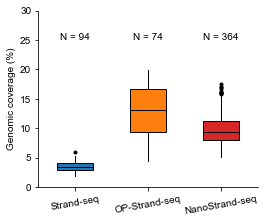

In [10]:
def get_genomic_coverage(name):
    df = pd.read_csv("results/%s.qc_pass.tsv" % name, sep="\t")
    array = df["GenomicCoverage"] * 100
    return array

np.random.seed(0)
names = ["Strand-seq", "OP-Strand-seq", "NanoStrand-seq"]
colors = ["blue", "orange", "red"]
colors = ["C0", "C1", "C3"]
w = 0.5
plt.figure(figsize=(3.8, 3.2))
for i, name in enumerate(names):
    ys = get_genomic_coverage(name)
    print(name, np.mean(ys), np.median(ys))
    
    if True:
        plt.boxplot([ys], positions=[i], widths=w, 
                    showcaps=False, 
                    showfliers=True, 
                    flierprops=dict(marker=".", markerfacecolor="black", markeredgecolor="black"),
                    medianprops=dict(color="black"), 
                    patch_artist=True, boxprops={"facecolor": colors[i]}
                   )
        
    if False:
        plt.violinplot([ys], positions=[i])
    
    if False:
        xs1 = (np.random.random(len(ys)) - 0.5) * w * 0.8 + i
        plt.scatter(xs1, ys, color="black", marker=".")
        
    plt.text(i, 25, "N = %d" % len(ys), ha="center")
plt.xticks(np.arange(len(names)), names, rotation=10)
plt.ylabel("Genomic coverage (%)")
plt.ylim(0, 30)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/genomic_coverage.final.pdf", dpi=300)